# Entscheidungsbäume
> Quelle 1: [Python Data Science Handbook](https://github.com/jakevdp/PythonDataScienceHandbook)<br>
> Quelle 2: [Medium](https://medium.com/@rnbrown/creating-and-visualizing-decision-trees-with-python-f8e8fa394176)

Zunächst einmal importieren wir die üblichen Bibliotheken für die Datenmanipulation und das Plotten.

In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()

## Grundidee von Entscheidungsbäumen

Enscheidungsbäume sind ein sehr intuitiver Ansatz zur Klassifikation von Objekten: man stellt eine Reihe von Fragen, die zur Klassifikation führen. Angenommen, man wolle etwa einen Klassifikator für Tiere haben, dann könnte man wie folgt vorgehen:

![](figures/eb_DE.png)
[figure source in Appendix](06.00-Figure-Code.ipynb#Decision-Tree-Example)

Hier erfolgen *Binär-Splits* resultierend in einem *Binär-Baum*, d.h., es werden immer nur Fragen gestellt, die mit *ja* oder *nein* (bzw. *wahr* oder *falsch*) beantwortet werden können. Dies ist im Allgemeinen recht effizient: in einem gut aufgebauten Baum wird jede Frage die Anzahl der Möglichkeiten ungefähr halbieren, so dass selbst bei einer großen Anzahl von Objekten und Klassen die Klassifikation rasch gelingt. 

Tatsächlich wurden bei den ersten Algorithmen wie dem nach wie vor gerne eingesetzten [CART](<https://de.wikipedia.org/wiki/CART_(Algorithmus%29)  (z.B. in `scikit-learn` in einer optimierten Variante) genau solche Binärbäume konstruiert, während etwa [C4.5](https://de.wikipedia.org/wiki/C4.5) und andere Algorithmen auch mehr als zwei Verzweigungen an einem Knoten zulassen.

Unabhängig von der möglichen Anzahl an Verzweigungen kommt es bei der Konstruktion des Entscheidungsbaums natürlich darauf an, in jedem Schritt die richtigen Fragen zu stellen. Im Wesentlichen muss dabei dasjenige *Attribut* und derjenige *Attributwert* gefunden werden, der eine möglichst effiziente Aufteilung erlaubt, d.h., man benötigt geeignete *Attributauswahlmaße*.
Hierfür gibt es verschiedene Ansätze wie den des *Informationsgewinn*s (basierend auf der *Entropie* im Rahmen der [Informationstheorie](https://de.wikipedia.org/wiki/Informationstheorie) von Shannon) oder den [Gini-Index](https://en.wikipedia.org/wiki/Decision_tree_learning#Gini_impurity) als Maß für die *Unreinheit* eines Knotens (für eine Übersicht über verschiedene mögliche Attributauswahlmaße siehe [dieses Paper](http://www.borgelt.net/papers/mldmd_96.pdf)). In diesem Zusammenhang sollte noch erwähnt werden, dass es mit einigen Entscheidungsbaum-Algorithmen möglich ist, sowohl *Klassifikation* als auch *Regression* durchzuführen (der weit verbreitete *CART* beispielsweise ist ein Akronym für **C**lassification **A**nd **R**egression **T**ree).

Wir wollen uns dem Thema zunächst einmal intuitiv nähern und mit Hilfe künstlich erzeugter Daten zunächst visuell und sozusagen von Hand die ersten Schritte einer Entscheidungsbaumkonstruktion durchführen, bevor wir den `DecisionTreeClassifier` aus `scikit-learn` zum Einsatz bringen nebst geeigneter Visualisierung des Ergebnisses.

### Händische Konstruktion eines Entscheidungsbaumes

Wir erzeugen zweidimensionale Daten, eingeteilt in vier Klassen:

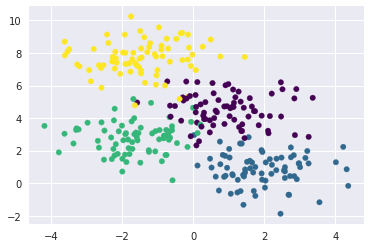

In [2]:
from sklearn.datasets import make_blobs

X, y = make_blobs(n_samples=300, centers=4,
                  random_state=0, cluster_std=1.0)
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis')
plt.show()

#### Wie kann man die Daten effizient aufteilen?
Wir versuchen es zunächst "von Hand". Dabei müssen wir jeweils zunächst entscheiden, ob wir parallel zur $x$-Achse (also durch eine Frage $y<y_s$ für einen geeigneten Splitwert $y_s$) aufteilen wollen oder parallel zur $y$-Achse (entsprechend $x<x_s$) und anschließend den geeigneten Splitwert $y_s$ oder $x_s$ finden. Dabei ist zu beachten, dass die dann entstehenden *reinen* Regionen (also diejenigen, in denen nur Vertreter einer einzigen Klasse zu finden sind) nicht weiter unterteilt werden, während Regionen, in denen noch keine Reinheit herrscht, weiter unterteilt werden. Dies macht man so lange, bis alle Objekte in reinen Regionen liegen (oder auch nicht, aber dazu mehr im Zusammenhang mit dem Thema Überanpassung).

Um nun in die Baumterminologie zu wechseln, entsprechen die Regionen dort den *Knoten* des Baumes, wobei reine Regionen *Blattknoten* und unsere Ausgangslage der *Wurzelknoten* sind.

In obigem Beispiel können wir die Daten zunächst bei $y=6.25$ trennen und erhalten damit oberhalb bereits eine reine Region oder einen Blattknoten. Dies ergibt einen Baum der *Tiefe 1* (oder, anders gesagt, mit einer *Ebene*).

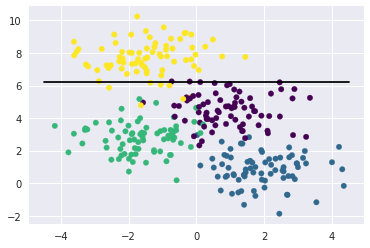

In [3]:
plt.scatter(X[:, 0], X[:, 1], c=y, s=30, cmap='viridis')
# Tiefe 1
plt.plot([-4.5,4.5],[6.25,6.25], color = 'black')
# Tiefe 2
# plt.plot([-.5,-.5],[-2.,6.25], color = 'gray')
# Tiefe 3
# plt.plot([-4.5,-.5],[4,4], color = 'cadetblue')
# plt.plot([-.5,4.5],[2.2,2.2], color = 'cadetblue')
plt.show()

Wir müssen dann als nächstes eine weitere Aufteilung der unteren (unreinen) Region vornehmen. Hier bietet sich eine Unterteilung nahe $x=0$ oder leicht besser vielleicht $x=-0.5$ an (Visualisierung durch Auskommentieren des Plotbefehls nach `#Ebene 2` in der obigen Codezelle). Zwar erhalten wir damit keinen reinen Knoten, aber wir konnten bereits einen Großteil der grünen Punkte von den lilanen und blauen trennen.

Die entstehenden Regionen würde man anschließend vielleicht beide wieder parallel zur $x$-Achse aufteilen; die linke bei $y=4$ und die rechte bei $y=2.2$ (wiederum zu visualisieren durch Auskommentieren der Plotbefehle nach `#Ebene 3`). Damit hat man links und rechts unten wieder große reine Regionen (also Blätter des Baumes) erzeugt, während man die unreinen kleineren Regionen noch weiter unterteilen müsste.

Dies tun wir aber nicht weiter von Hand, sondern wir lassen nun wieder `scikit-learn` für uns arbeiten. Vorab zeigen wir hier bereits die Visualisierungen der ersten vier Ebenen und sehen, dass wir mit unserer händischen Herangehensweise gar nicht mal so schlecht gelegen haben.

![](figures/05.08-decision-tree-levels.png)
[Code der Abbildung](06.00-Figure-Code.ipynb#Decision-Tree-Levels)

In `scikit-Learn` verwenden wir den `DecisionTreeClassifier`:

In [4]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

Den Entscheidungsbaum können wir dann zunächst einmal wie folgt veranschaulichen:

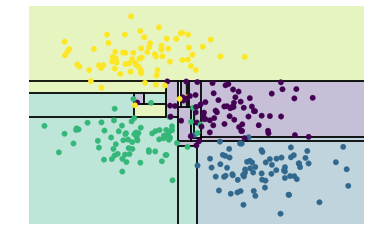

In [5]:
# helpers_05_08.py steht zur Verfügung
import helpers_05_08
helpers_05_08.visualize_tree(DecisionTreeClassifier(), X, y)

Üblicher ist natürlich die Darstellung als Baum. Dies geschieht in `scikit-learn` über eine Methode `export_graphviz`, der man die Featurenamen (also die Namen der Attribute) sowie die Klassennamen mitgeben kann. 
Mit Hilfe von `graphviz` und des `pydotplus`-Pakets (muss beides in Anaconda **nachinstalliert** werden) kann man den Entscheidungsbaum also gut visualisieren (und durch Angabe der `feature_names` und `class_names` gut interpretierbar machen):

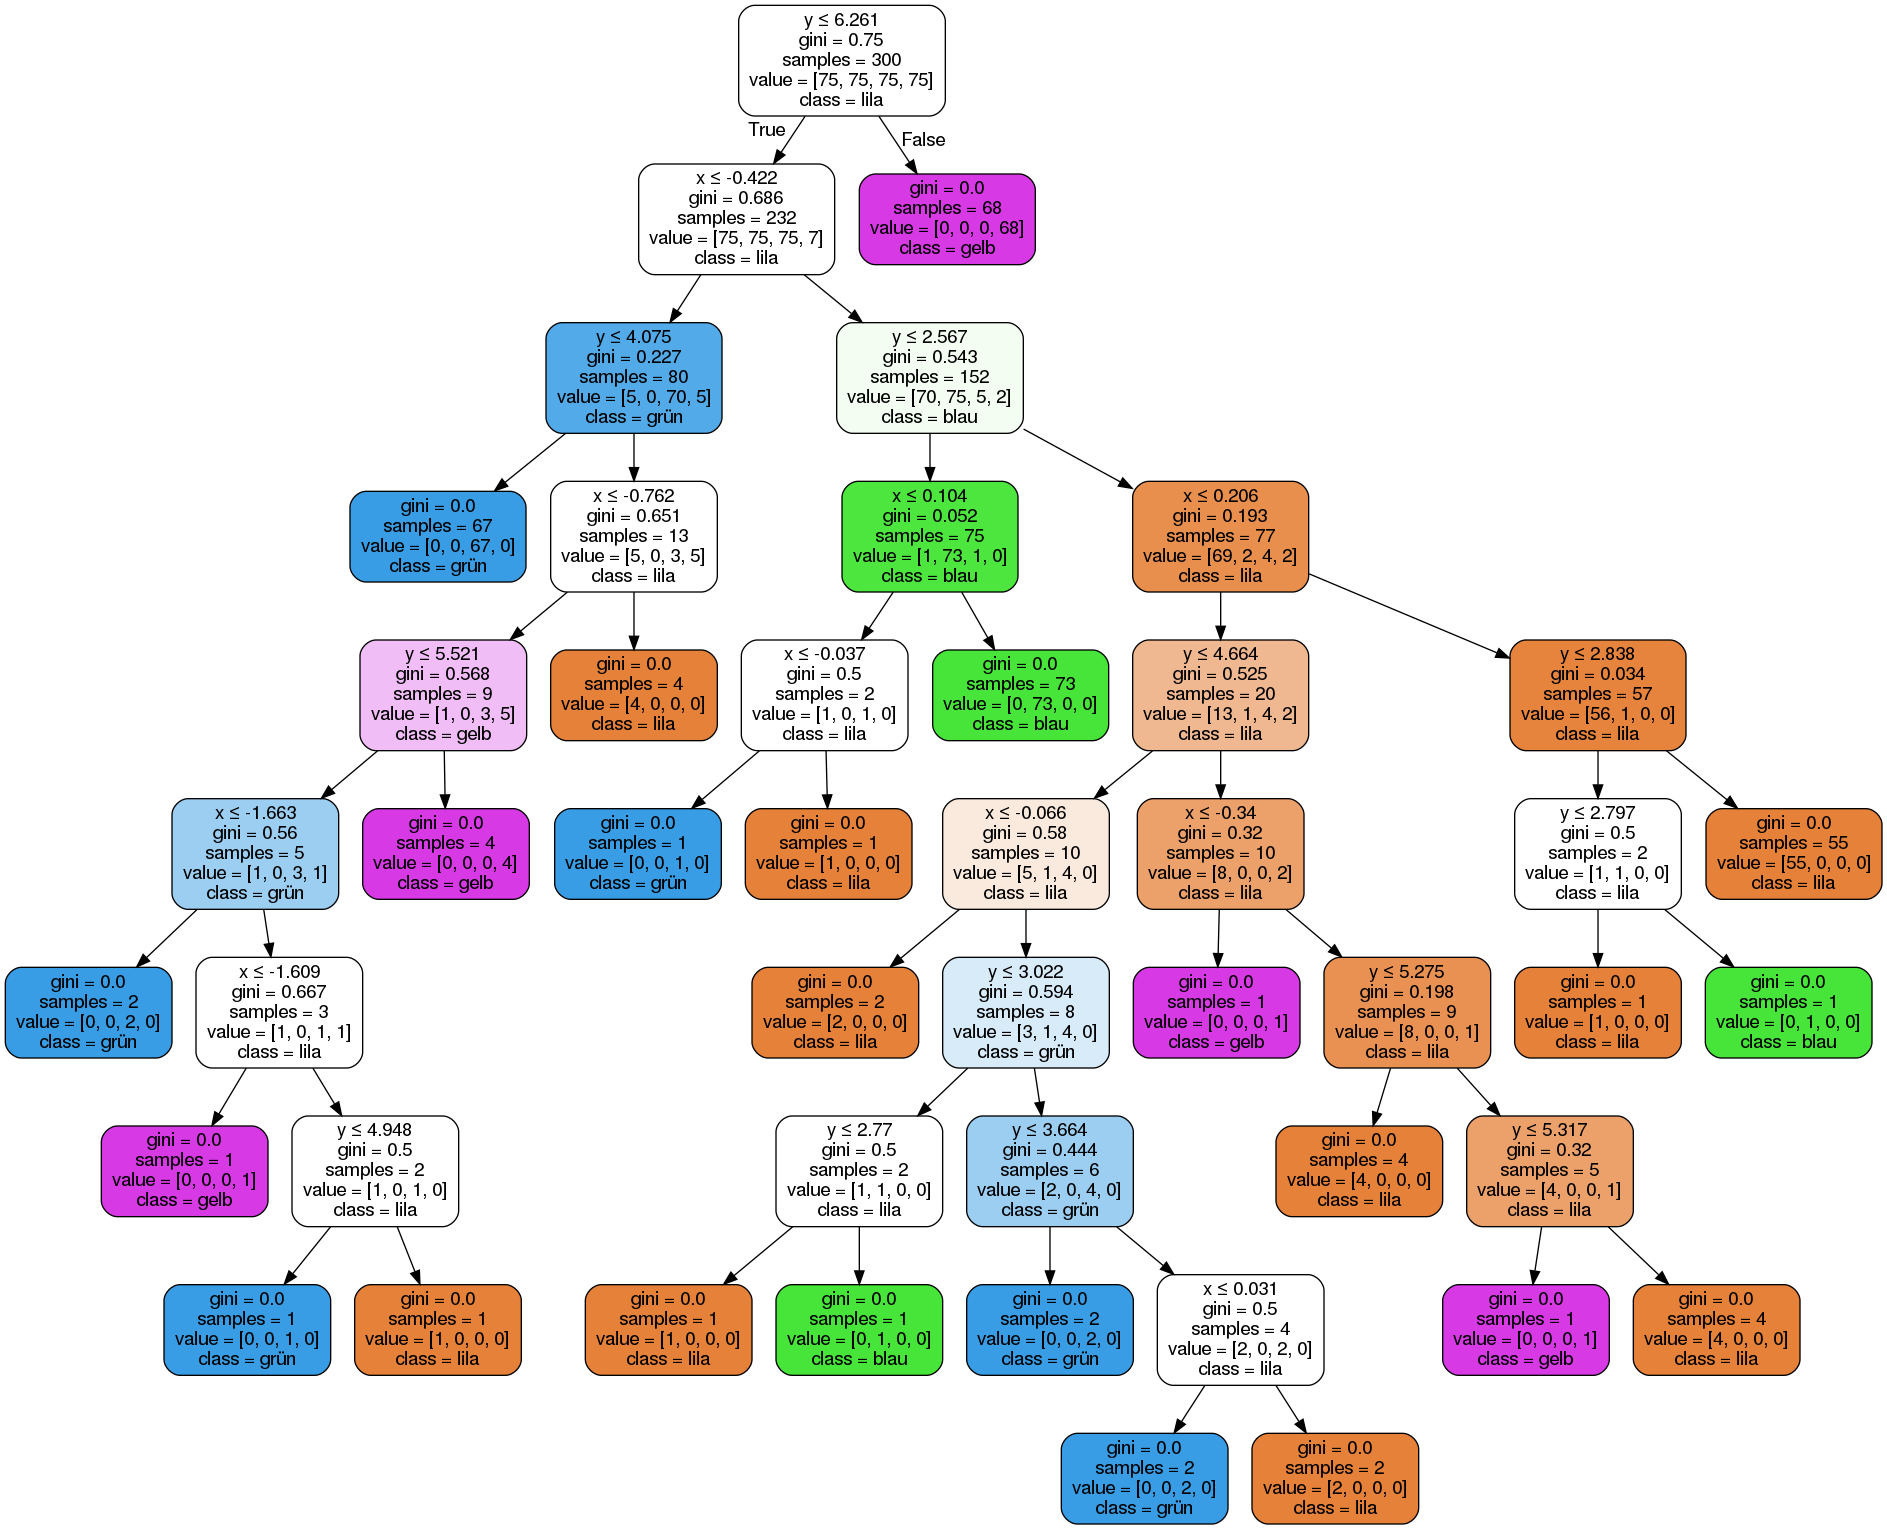

In [6]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(tree, out_file=dot_data,  
                filled=True, rounded=True,
                # was dient zur Aufteilung
                feature_names=['x','y'],
                # wie heißen die Klassen
                class_names=['lila','blau','grün','gelb'],
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

In den einzelnen Knoten bis zur Ebene 3 können wir nochmal gut sehen, dass wir mit unserer händischen Aufteilung ganz gut liegen. Außerdem ist zu sehen, dass die Blattknoten durch einen Gini-Index von 0 gekennzeichnet sind, was genau der Intrepretation als *reine* Knoten entspricht.

Wer dieses Notebook ausführen kann, der kann mit dem beigefügten [Hilfsskript](06.00-Figure-Code.ipynb#Helper-Code) einige Konstruktionsschritte des Baumes interaktiv visualisieren:

In [7]:
# helpers_05_08 is found in the online appendix
# import helpers_05_08
helpers_05_08.plot_tree_interactive(X, y);

interactive(children=(Dropdown(description='depth', index=2, options=(1, 3, 5), value=5), Output()), _dom_clas…

Man beachte, dass mit zunehmender Tiefe des Baumes die Regionen immer seltsamer aussehen. So gibt es auf Ebene 5 beispielsweise zwischen der grünen und der blauen Region eine hohe, dünne Region lila (mit einem einzigen Element).
Es wird sofort klar, dass dies eher an den spezifischen Eigenschaften und dem Rauschen der vorliegenden Daten und weniger an deren wirklicher Verteilung liegt. Somit haben wir bereits auf Ebene 5 eine *Überanpassung* in den Daten.

### Überanpassung bei Entscheidungsbäumen

Leider ist die Überanpassung eine generelle Eigenschaft von Entscheidungsbäumen: es ist ein Leichtes, mit dem Baum zu weit in die Tiefe zu gehen und damit den Baum genau den vorliegenden Daten anzupassen und nicht der eigentlich zugrunde liegenden Verteilung, der die Daten entstammen. 

Dies kann man auch dadurch veranschaulichen, dass man betrachtet, wie sich Bäume unterscheiden, die jeweils auf komplementären Hälften der Daten trainiert wurden:

![](figures/05.08-decision-tree-overfitting.png)
[Code der Abbildung](06.00-Figure-Code.ipynb#Decision-Tree-Overfitting)

Man sieht, dass in einigen Gebieten die beiden Bäume gut übereinstimmen (etwa in den vier Ecken), während sie anderswo zu sehr unterschiedlichen Klassifikationen führen. Dies gilt insbesondere in den Grenzgebieten unterschiedlicher Gebiete.

Verwendet man zur Klassifikation Entscheidungsbäume, so tritt man der Überanpassung durch *Beschneiden* der Bäume (engl. [Pruning](https://de.wikipedia.org/wiki/Pruning)).

Die entscheidende Erkenntnis ist hier aber, dass diese Inkonsistenzen meist dort auftreten, wo die Klassifikation weniger eindeutig ist. Daher wäre es vermutlich vernünftig, die Information *beider* Bäume zu benutzen, um ein besseres Ergebnis zu erhalten. 

Wer dieses Notebook ausführen kann, der kann wiederum mit dem beigefügten [Hilfsskript](06.00-Figure-Code.ipynb#Helper-Code) verschiedene mit zufällig ausgewählten Teilmengen der Ausgangsdaten erzeugte Bäume interaktiv visualisieren:

In [8]:
# helpers_05_08 is found in the online appendix
#import helpers_05_08
helpers_05_08.randomized_tree_interactive(X, y)

interactive(children=(Dropdown(description='random_state', options=(0, 20, 50, 100), value=0), Output()), _dom…

So, wie die Verwendung der Information zweier Bäume unsere Ergnisse verbessern kann, so dürfen wir erwarten, dass die Verwendung mehrerer Bäume eine weitere Verbesserung bewirken würde. Das ist genau die Motivation für [Ensemble Methoden](https://de.wikipedia.org/wiki/Ensemble_learning).

## Klassifikation des Iris-Datensatzes
Der bekannte Iris-Datensatz wird mit `scikit-learn` schon mitgeliefert. Wir benutzen ihn daher, um zu schauen, wie der Klassifikator aus `scikit-learn` damit zurecht kommt.

In [9]:
import sklearn.datasets as datasets
iris=datasets.load_iris()
df=pd.DataFrame(iris.data, columns=iris.feature_names)
y=iris.target

Nun trainieren wir wieder den Entscheidungsbaum.

In [10]:
dtree=DecisionTreeClassifier()
dtree.fit(df,y)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Diesen können wir wieder visualisieren:

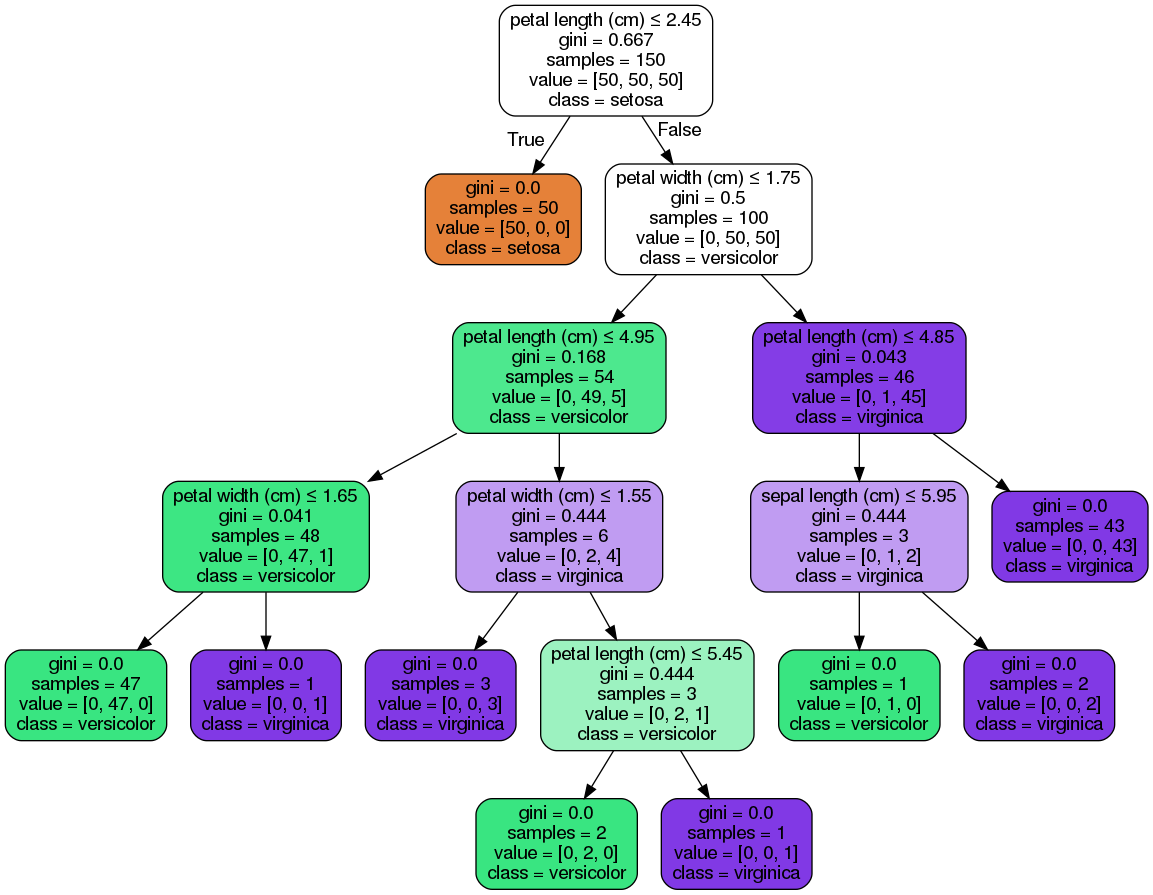

In [11]:
from sklearn.externals.six import StringIO  
from IPython.display import Image  
from sklearn.tree import export_graphviz
import pydotplus
dot_data = StringIO()
export_graphviz(dtree, out_file=dot_data,  
                feature_names = iris.feature_names,
                class_names = iris.target_names,
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Hier fällt auf, dass wir bereits ganz zu Anfang allein durch die Länge der Petalblätter in der Lage sind, sämtliche Iris-setosa richtig zu klassifizieren. Anschließend haben wir also nur noch ein binäres Problem für die beiden anderen Arten.

## Kategoriale Attribute

In unseren bisherigen Beispielen hatten die Attribute allesamt numerische Werte (Blattdimensionen beim Iris-Datensatz, sowie $x$ und $y$ Werte für die künstlich erzeugten Punkte im Eingangsbeispiel). Tatsächlich kann der Entscheidungsbaumalgorithmus in `scikit-learn` nur numerische Werte verarbeiten. Damit stellt sich die Frage, wie wir etwa mit unserem bereits bekannten Gutschienbeispiel umgehen würden.

Zur Erinnerung: Wir betrachten das folgende Beispiel, welches fiktive (verdichtete)
Daten zu einer Problemstellung eines Versandhändlers behandelt. Die Firma denkt
darüber nach, ihren Umsatz mittels einer Marketingkampagne zu steigern.
Dabei will die Firma nur solchen Kunden einen Gutschein für weitere
Bestellungen senden, bei denen zu erwarten ist, dass sie nicht ohnehin
innerhalb von 90 Tagen eine neue Bestellung aufgeben würden (da ja sonst
Geld verloren ginge). Es soll eine Vorhersage zum Gutscheinversand auf
Basis der Kenntnis über den Ablauf vergangener Bestellungen erfolgen,
wobei die Attribute *Verspätung, Kunde, Posten* und *Rücksendung*
betrachtet werden und mittels dieser darauf geschlossen werden soll, ob
eine Neubestellung (innerhalb von 90 Tagen) erfolgen wird (was dann
hieße, dass kein Gutschein zu senden wäre). Die zugehörigen Daten zeigt
die folgende Tabelle. Dabei bedeuten die Werte in der Spalte `Kunde`
**F**rau, **M**ann und **U**nternehmen.

   Fall |  Verspätung |  Kunde  | Posten |  Rücksendung  | ***Neubestellung?***
  :--------:|:--------------: | :---------: |:----------:| :---------------: |:------------------:
      1     |       lang      |      M      |   einzel   |       nein        |        nein
      2     |       lang      |      M      |   einzel   |        ja         |        nein
      3     |      keine      |      M      |   einzel   |       nein        |         ja
      4     |       kurz      |      F      |   einzel   |       nein        |         ja
      5     |       kurz      |      U      |  mehrere   |       nein        |         ja
      6     |       kurz      |      U      |  mehrere   |        ja         |        nein
      7     |      keine      |      U      |  mehrere   |        ja         |         ja
      8     |       lang      |      F      |   einzel   |       nein        |        nein
      9     |       lang      |      U      |  mehrere   |       nein        |         ja
      10    |       kurz      |      F      |  mehrere   |       nein        |         ja
      11    |       lang      |      F      |  mehrere   |        ja         |         ja
      12    |      keine      |      F      |   einzel   |        ja         |         ja
      13    |      keine      |      M      |  mehrere   |       nein        |         ja
      14    |       kurz      |      F      |   einzel   |        ja         |        nein

  : Beispieldaten für Entscheidungen zum Gutscheinversand<span
  data-label="tab:dmgutbsp"></span>

Hierbei müssen also nur *binäre* Entscheidungen (Ja/Nein) getroffen
werden. Etwas allgemeiner geht es darum, die Datensätze in zwei
*Klassen* einzuteilen. Mit den obigen Trainingsdaten wollen wir dann
für neue Datensätze Vorhersagen treffen, zu welcher Klasse diese wohl
gehören.

Allerdings haben wir hier eben kategoriale Werte der Attribute und Klassen. Daher müssen wir nun nicht nur theoretisch diese Werte auf Zahlen abbilden (wie bei der Einführung der Notation für Klassifikationsprobleme), sondern wir müssen diese Umcodierung praktisch vornehmen.

Zunächst lesen wir die Daten aber ein.

In [12]:
df=pd.read_csv('data/gutscheine.csv', sep=';')
df

,Fall,Verspaetung,Kunde,Posten,Ruecksendung,Neubestellung
0,1,lang,M,einzel,nein,nein
1,2,lang,M,einzel,ja,nein
2,3,keine,M,einzel,nein,ja
3,4,kurz,F,einzel,nein,ja
4,5,kurz,U,mehrere,nein,ja
5,6,kurz,U,mehrere,ja,nein
6,7,keine,U,mehrere,ja,ja
7,8,lang,F,einzel,nein,nein
8,9,lang,U,mehrere,nein,ja
9,10,kurz,F,mehrere,nein,ja


Für die Umcodierung benutzen wir den [LabelEncoder](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html) aus den Preprocessing-Methoden von `scikit-learn`.

In [13]:
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
df_enc=df.apply(le.fit_transform)
df_enc.head()

,Fall,Verspaetung,Kunde,Posten,Ruecksendung,Neubestellung
0,0,2,1,0,1,1
1,1,2,1,0,0,1
2,2,0,1,0,1,0
3,3,1,0,0,1,0
4,4,1,2,1,1,0


Nun extrahieren wir die Klassen und die Featurematrix aus dem DataFrame.

In [14]:
# Klassenvektor
y = df_enc['Neubestellung']
y.head()

0    1
1    1
2    0
3    0
4    0
Name: Neubestellung, dtype: int64

In [15]:
# Featurematrix
X=df_enc.loc[:,['Verspaetung','Kunde','Posten','Ruecksendung']]
X.head()

,Verspaetung,Kunde,Posten,Ruecksendung
0,2,1,0,1
1,2,1,0,0
2,0,1,0,1
3,1,0,0,1
4,1,2,1,1


Nun können wir wieder den Klassifikator trainieren. Diesmal verwenden wir aber mal statt des Gini-Index das Kriterium des Informationsgewinns durch Angabe der Option `criterion='entropy'` im `DecisionTreeClassifier`.

In [16]:
dtree_cat=DecisionTreeClassifier(criterion='entropy')
dtree_cat.fit(X,y)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

Nun fehlt noch die Visualisierung.

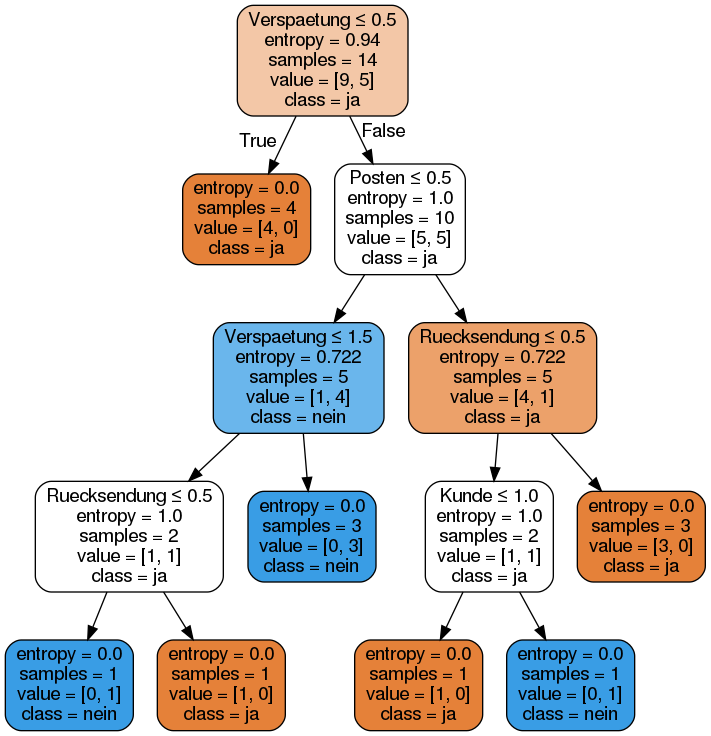

In [17]:
dot_data = StringIO()
export_graphviz(dtree_cat, out_file=dot_data,
                feature_names = X.columns,
                class_names = ['ja','nein'],
                filled=True, rounded=True,
                special_characters=True)
graph = pydotplus.graph_from_dot_data(dot_data.getvalue())  
Image(graph.create_png())

Hier zeigt sich bei der Interpretation des Baumes eine Schwierigkeit, denn die Frage im Wurzelknoten ob die Verspätung $\le 0.5$ sei wirkt bei den diskreten Werten doch etwas komisch. Sie entspricht der Frage, ob die Verspätung gleich 0 ist, was hier *zufällig* keiner vorliegenden Verspätung entspricht, da der kategoriale Wert *keine* auf 0 umkodiert wurde. Man darf also nicht der Versuchung erliegen, hier eine Semantik hinein zu interpretieren, die nicht da ist! So wurde sowohl bei der Rücksendung als auch beim Klassenlabel für die Neubestellung *nein* durch 1 und *ja* durch 0 kodiert - also gerade anders herum, als man es in der Binärinterpretation eigentlich tun würde. Bei der Umkodierung geht es nur darum, die *Unterscheidbarkeit* zu erhalten, denn mehr gibt es nicht her.

Das beschließt die kurze Einführung in Entscheidungsbäume.